# Problem description
This project’s task is to find frames with people from a security camera video. The project idea is from my former company’s working experience. My former company is a factory, and there are a lot of security cameras in the factory. One day, a manager found someone hiding a box of not good products in a corner at night, the manager wanted to find who does this. He needs to check the recorded video, but the video was long, last for about 10 hours. It was very time-consuming. I want to use machine learning to solve this problem, filtering out the frames without people, then the manager only checks the frames with people. Most frames have nobody inside. The benefit is to save the manager time. <br>
I calculated the consecutive frames dis-similarity. I use Euclidean distance methods. If the distance is small, it means the consecutive frames are similar, if the distance is large, it means the consecutive frames are not similar. If the consecutive frames are not similar, most probably, people move in the video. <br>
 The dataset is in Kaggle. 
https://www.kaggle.com/chunshanfeng/security-camera-video

# Roadmap
Project road map. First step, extracting frames from the video. Then I tried two methods to solve this problem. <br>
Solution one: use the image clustering method.<br>
Solution two: calculating neighbouring images dis-similarity.<br>

I solved this problem in the following steps<br>

1, read the video file<br>
2, extract frames from the video<br>
3, change the frames to grey images<br>
4, change images to smaller sizes<br>
5, calculate neighbouring images distance<br>
6, clip the video then connect together<br>
7, conclusion<br>

### 1. read the video file

In [51]:
# import libraries
import cv2
import os
import datetime
import time
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline 
#import warnings
#warnings.filterwarnings("ignore")

# Read the video    
vidcap = cv2.VideoCapture('security.mp4')

### 2, extract frames from the video
 I capture image in each one second. Usually, there are over 20 frames in one second. If we capture every frame, the time interval is tiny, even people move in the video, the consecutive frames don't have much difference. The small interval is not good.  If people move in the video, usually the time span will be over four seconds, so I choose to capture image in each one second.

In [52]:
from PIL import Image
from matplotlib.pyplot import imshow
sec = 0
frameRate = 1   #//it will capture image in each 1 second
count=1

frame_array = []
def getFrame(sec):
    # This function get frames from video
    global result,diff
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    frame_array.append(image)
    return hasFrames

success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
   

I display several images

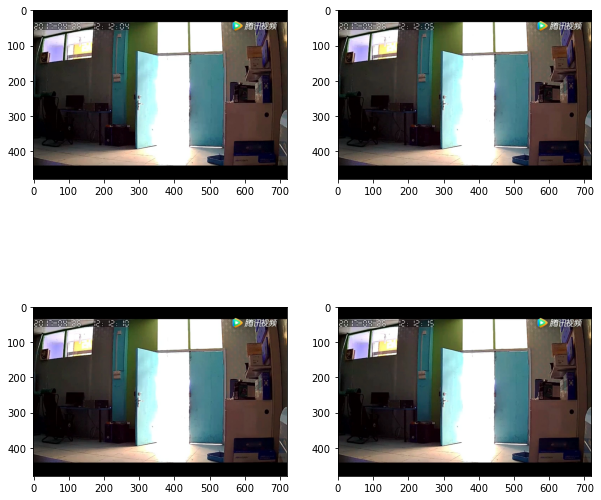

In [53]:
import matplotlib.pyplot as plt
img = Image.fromarray(frame_array[0], 'RGB')

rows=2
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(frame_array):
            axes[i, j].imshow(frame_array[img_count])
            img_count+=5

### 3, change the frames to grey images

A grayscale (or graylevel) image is simply one in which the only colors are shades of gray. The reason is that less information needs to be provided for each pixel. we can calculate faster.

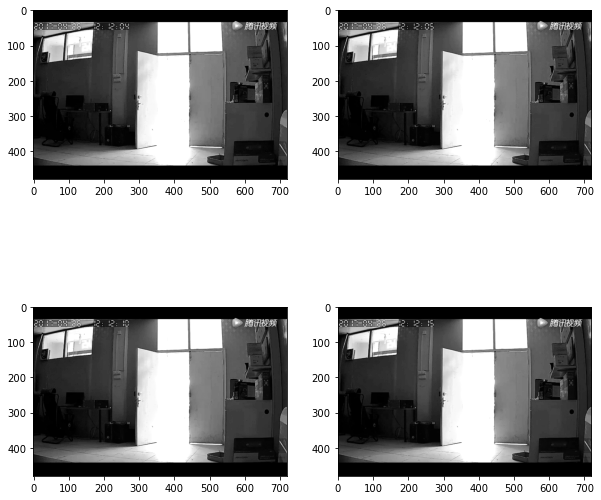

In [54]:
grey_frame_array = []  # save grey images in this list

for i in range(len(frame_array)-1):
    gray = cv2.cvtColor(frame_array[i], cv2.COLOR_BGR2GRAY)
    grey_frame_array.append(gray)
    

# I display four grey images    
rows=2
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(frame_array):
            axes[i, j].imshow(grey_frame_array[img_count],cmap='gray')
            img_count+=5

### 4, change images to smaller sizes
The reason is that we can calculate faster with smaller sizes of images.

In [55]:
resized_array = [] # save smaller sizes images in this list

width=128
height=72
dim = (width, height)        
for i in range(len(grey_frame_array)):
        # Change to smaller size
        img=grey_frame_array[i]
       
        # Resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
        # scale pixel values to the range 0-1, reduce the outlier pixel value affect
        resized=resized/255
        resized_array.append(resized)

### 5, calculate neighbouring images distance

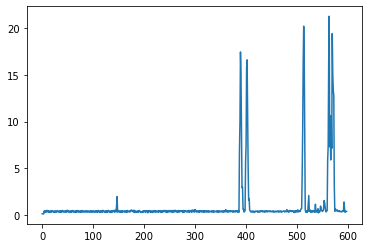

In [56]:
diff=[] # save the neighbouring images distance in this list
for i in range(len(resized_array)):
     if i>0:
          
        lastimage=resized_array[i-1]
        image=resized_array[i]
        difference = cv2.subtract(lastimage, image)
        diff2= np.sum(difference**2)
        diff2=np.sqrt(diff2)
        diff.append(diff2)    
plt.plot(diff)
plt.show()

From the above chart, we can find three areas have peaks. The continuous images are not similar in these three areas. It seems that we can choose the distance threshold value 3 to distinguish these three peaks area with other flat areas.

### 6, clip the video then connect together

In [58]:
from moviepy.editor import *
clip = VideoFileClip('security.mp4')
final_clip=clip.subclip(1, 1)
start_time=0
end_time=0

threshold=int(input('Please enter the threshlod, the reference value is 3: '))

for i in range(len(diff)):
    if i>0:
        if diff[i]>threshold and diff[i-1]<threshold:
            start_time=i+1
        if diff[i]<threshold and diff[i-1]>threshold:
            end_time=i+1
        if end_time>start_time:
            clip2=clip.subclip(start_time, end_time)
            final_clip = concatenate_videoclips([final_clip,clip2])
            end_time=0
            start_time=0

ipython_display(final_clip)

Please enter the threshlod, the reference value is 3: 10


chunk:   1%|▎                                                                | 2/353 [00:00<00:25, 13.51it/s, now=None]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


t:   2%|█▏                                                                   | 7/400 [00:00<00:05, 69.31it/s, now=None]

MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 7, Conclusion
From the final smaller video, I think using Euclidean distance methods to calculate the distance of the neighbouring image is an effective method to find the frames with people in a security camera video.